In [1]:
import polars as pl
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
class DataEngineering:
    def __init__(self, data):
        """
        Inicializa la clase con el DataFrame de Polars.
        :param data: DataFrame con los datos a procesar.
        """
        self.data = data

    def limpiar_fechas(self):
        """
        Normaliza y corrige los formatos de las columnas 'start_time' y 'end_time'.
        - Reemplaza '/' por '-' en las fechas.
        - Intenta parsear fechas en dos formatos: '%Y-%m-%d %H:%M:%S' y '%m-%d-%Y %H:%M'.
        """
        def unify_datetime_format(column):
            return column.str.replace_all("/", "-")

        # Reemplaza '/' por '-' en las fechas
        self.data = self.data.with_columns([
            unify_datetime_format(pl.col("start_time")).alias("start_time"),
            unify_datetime_format(pl.col("end_time")).alias("end_time")
        ])

        # Parseo de fechas con dos formatos posibles
        self.data = self.data.with_columns([
            pl.col("start_time")
            .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False)
            .alias("start_time_main"),
            pl.col("end_time")
            .str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S", strict=False)
            .alias("end_time_main"),
        ]).with_columns([
            # Maneja los nulos intentando otro formato
            pl.when(pl.col("start_time_main").is_null())
            .then(pl.col("start_time").str.strptime(pl.Datetime, format="%m-%d-%Y %H:%M", strict=False))
            .otherwise(pl.col("start_time_main")),
            pl.when(pl.col("end_time_main").is_null())
            .then(pl.col("end_time").str.strptime(pl.Datetime, format="%m-%d-%Y %H:%M", strict=False))
            .otherwise(pl.col("end_time_main"))
        ]).drop(["start_time_main", "end_time_main"])

    def calcular_distancia_km(self):
        """
        Calcula la distancia entre los puntos 'start_lat', 'start_lon' y 'end_lat', 'end_lon' en metros.
        """
        # Convierte las columnas de coordenadas a tipo float
        self.data = self.data.with_columns([
            pl.col("start_lat").cast(pl.Float64, strict=False),
            pl.col("start_lon").cast(pl.Float64, strict=False),
            pl.col("end_lat").cast(pl.Float64, strict=False),
            pl.col("end_lon").cast(pl.Float64, strict=False)
        ]).drop_nulls()  # Elimina registros con nulos

        try:
            self.data = self.data.filter(pl.col("passholder_type") != "NULL")     
        except:
            None
        # Conversión a GeoDataFrames y cálculo de distancia
        df_pd = self.data.to_pandas()
        gdf_start = gpd.GeoDataFrame(
            df_pd, geometry=gpd.points_from_xy(df_pd["start_lon"], df_pd["start_lat"]), crs="EPSG:4326"
        )
        gdf_end = gpd.GeoDataFrame(
            df_pd, geometry=gpd.points_from_xy(df_pd["end_lon"], df_pd["end_lat"]), crs="EPSG:4326"
        )

        # Convierte a metros y calcula distancia
        gdf_start, gdf_end = gdf_start.to_crs(epsg=3857), gdf_end.to_crs(epsg=3857)
        distancias_mts = round(gdf_start.geometry.distance(gdf_end.geometry), 1)

        # Agrega la distancia calculada al DataFrame
        self.data = self.data.with_columns(pl.Series(name="distancia_mts", values=distancias_mts))

    def agregar_franja_horaria(self):
        """
        Agrega la columna 'franja_horaria' según la hora de 'start_time'.
        """
        def categorizar_hora(hora):
            if 0 <= hora < 6:
                return "Madrugada"
            elif 6 <= hora < 12:
                return "Mañana"
            elif 12 <= hora < 18:
                return "Tarde"
            else:
                return "Noche"

        # Aplica la función para categorizar las horas
        self.data = self.data.with_columns(
            pl.col("start_time").dt.hour().map_elements(categorizar_hora, return_dtype=pl.String).alias("franja_horaria")
        )

    def agregar_estacion_del_ano(self):
        """
        Agrega la columna 'estacion_año' según el mes de 'start_time'.
        """
        def estacion_mes(mes):
            if mes in [12, 1, 2]:
                return "Invierno"
            elif mes in [3, 4, 5]:
                return "Primavera"
            elif mes in [6, 7, 8]:
                return "Verano"
            else:
                return "Otoño"

        # Aplica la función para determinar la estación
        self.data = self.data.with_columns(
            pl.col("start_time").dt.month().map_elements(estacion_mes, return_dtype=pl.String).alias("estacion_año")
        )

    def agregar_tiempo_promedio_estaciones(self):
        """
        Calcula y agrega el tiempo promedio de duración por estación y pares de estaciones.
        """
        # Tiempo promedio por estación de inicio
        duracion_promedio = (
            self.data.group_by("start_station")
            .agg(pl.col("duration").mean().alias("tiempo_promedio_estacion"))
        )
        self.data = self.data.join(duracion_promedio, on="start_station")

        # Tiempo promedio por pares de estaciones (inicio y fin)
        duracion_promedio_pares = (
            self.data.group_by(["start_station", "end_station"])
            .agg(pl.col("duration").mean().alias("tiempo_promedio_pares"))
        )
        self.data = self.data.join(duracion_promedio_pares, on=["start_station", "end_station"])

    def agregar_variables_adicionales(self):
        """
        Crea nuevas características adicionales para el análisis.
        - Día de la semana, hora de inicio.
        - Normalización de duración.
        - Velocidad promedio en metros por hora.
        - Indicador si la estación inicial y final son diferentes.
        - Frecuencia de viajes por día.
        - Duración promedio por tipo de usuario.
        - Frecuencia de uso de cada bicicleta.
        """
        # Extraer día y hora de inicio
        self.data = self.data.with_columns([
            pl.col("start_time").dt.weekday().alias("dia_semana"),
            pl.col("start_time").dt.hour().alias("hora_inicio")
        ])

        # Generar características adicionales
        self.data = self.data.with_columns([
            (pl.col("duration") / pl.col("duration").mean()).alias("duration_normalized"),
            (pl.col("distancia_mts") / (pl.col("duration") / 60)).alias("velocidad_promedio_mts"),
            (pl.col("start_station") != pl.col("end_station")).cast(pl.Int8).alias("diferente_estacion")
        ])

        # Frecuencia de viajes por día
        frecuencia_dia = (
            self.data.group_by("dia_semana")
            .agg(pl.len().alias("viajes_por_dia"))
        )
        self.data = self.data.join(frecuencia_dia, on="dia_semana")

        # Frecuencia de uso de cada bicicleta
        bike_usage = (
            self.data.group_by("bike_id")
            .agg(pl.len().alias("bike_usage"))
        )
        self.data = self.data.join(bike_usage, on="bike_id")

        # Crear columnas 'año' y 'mes' a partir de 'start_time'
        self.data = self.data.with_columns([
            pl.col("start_time").dt.year().alias("year"),
            pl.col("start_time").dt.month().alias("month")
        ])


        # Calcular el promedio de plan_duration por 'año' y 'mes'
        promedio_plan_mes = (
            self.data
            .group_by(["year", "month"])
            .agg(pl.mean("plan_duration").alias("promedio_plan_duration_mes"))
        )
        
        self.data = self.data.join(promedio_plan_mes, on=["year", "month"])

        # Calcular el promedio de plan_duration por bike_id
        promedio_plan_por_bicicleta = (
            self.data
            .group_by("bike_id")
            .agg(pl.mean("plan_duration").alias("promedio_plan_duration_bicicleta"))
        )
        
        # Unir el promedio al DataFrame original
        self.data = self.data.join(promedio_plan_por_bicicleta, on="bike_id")
                        

    def ejecutar(self):
        """
        Ejecuta todas las transformaciones secuenciales.
        """
        self.limpiar_fechas()
        self.calcular_distancia_km()
        self.agregar_franja_horaria()
        self.agregar_estacion_del_ano()
        self.agregar_tiempo_promedio_estaciones()
        self.agregar_variables_adicionales()
        return self.data

In [3]:
# Cargar datos
train = pl.read_csv("./Data/train_set.csv", ignore_errors=True)
data_engineer = DataEngineering(train)
train=data_engineer.ejecutar()

### 2. Modelos De Machine Learning

In [4]:
# Ahora que ya extrajimos toda la información necesaria, podemos eliminar start_time y end_time
columns_delete = ["start_time", "end_time","trip_route_category","start_station","end_station","bike_id"]
train = train.drop(columns_delete)

train=train[["trip_id","duration", "franja_horaria", "tiempo_promedio_estacion", "distancia_mts", "estacion_año",
     "tiempo_promedio_pares","passholder_type", "dia_semana","hora_inicio", "duration_normalized", "velocidad_promedio_mts",
     "diferente_estacion","viajes_por_dia","bike_usage",'year','month','promedio_plan_duration_mes','promedio_plan_duration_bicicleta']]

In [5]:
# Identificar columnas
numerical_cols = ['duration', 'tiempo_promedio_estacion', 'distancia_mts', 
                  'tiempo_promedio_pares', 'duration_normalized', 'velocidad_promedio_mts',
                  'viajes_por_dia', 'bike_usage', 'promedio_plan_duration_mes', 
                  'promedio_plan_duration_bicicleta']

categorical_cols = ['franja_horaria', 'estacion_año', 'dia_semana', 'hora_inicio', 'year', 'month']

target_col = 'passholder_type'

# Codificar la variable objetivo con LabelEncoder
label_encoder = LabelEncoder()
train = train.with_columns(
    pl.Series(name='target_encoded', values=label_encoder.fit_transform(train[target_col].to_list()))
)

In [6]:
scaler = StandardScaler()
numerical_data = scaler.fit_transform(train.select(numerical_cols).to_numpy())

# Codificar columnas categóricas con OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
categorical_data = encoder.fit_transform(train.select(categorical_cols).to_numpy())

In [7]:
# Combinar datos preprocesados
X_preprocessed = np.hstack((numerical_data, categorical_data))
y = train['target_encoded'].to_numpy()

# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [8]:
from xgboost import XGBClassifier

# Configurar el modelo con GPU
model = XGBClassifier(
    tree_method="hist",
    device="cuda:0",
    objective="multi:softprob",
    eval_metric="mlogloss"
)

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluación
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 72.08%


C:\Users\jfgarcia\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:09:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Distribución de Predicciones:
          Clase  Frecuencia (%)  Cantidad
0  Monthly Pass       71.071756     96035
1       Walk-up       27.291969     36878
2   Annual Pass        0.813327      1099
3  One Day Pass        0.774104      1046
4     Flex Pass        0.048104        65
5       Testing        0.000740         1


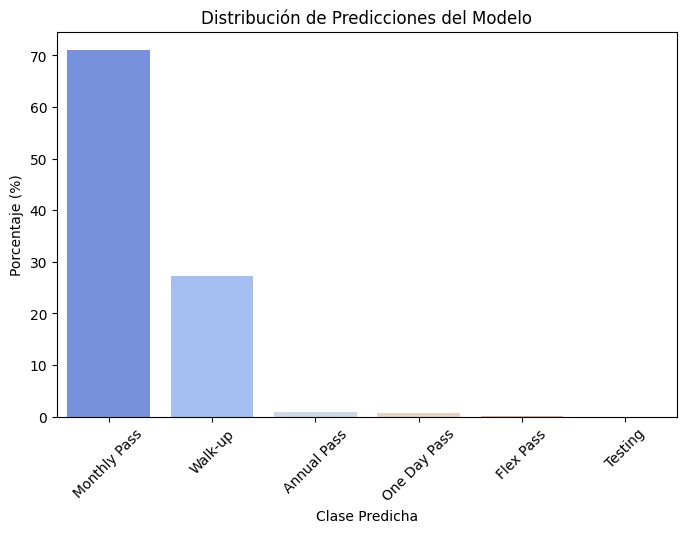

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


# Realizar predicciones
predictions = model.predict(X_test)
# Convertir predicciones numéricas a etiquetas originales
predicted_labels = label_encoder.inverse_transform(predictions)

# Crear un DataFrame temporal para analizar las predicciones
predictions_data = pd.DataFrame({
    "Predicted_Class": predicted_labels
})

# Calcular la distribución de las predicciones
predictions_distribution = predictions_data['Predicted_Class'].value_counts(normalize=True) * 100
predictions_counts = predictions_data['Predicted_Class'].value_counts()

# Crear un DataFrame con la distribución de las predicciones
predictions_df = pd.DataFrame({
    "Clase": predictions_distribution.index,
    "Frecuencia (%)": predictions_distribution.values,
    "Cantidad": predictions_counts.values
})

print("Distribución de Predicciones:")
print(predictions_df)

# Graficar la distribución de las predicciones
plt.figure(figsize=(8, 5))
sns.barplot(
    x=predictions_distribution.index,
    y=predictions_distribution.values,
    hue=predictions_distribution.index,  # Asignar x a hue
    palette='coolwarm',
    legend=False  # Evitar la leyenda redundante
)
plt.title("Distribución de Predicciones del Modelo")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Clase Predicha")
plt.xticks(rotation=45)
plt.show()

### 3. Tunnig Parameter - XGBoost

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Configurar los parámetros para hacer tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'tree_method': ['hist'],
    'device': ['cuda:0']  # Ejecutar en GPU
}

# Instanciar el modelo
model = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss')

# Realizar GridSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=5, scoring='recall_weighted')
random_search.fit(X_train, y_train)

# Mostrar los mejores parámetros
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# Evaluar el modelo con los mejores parámetros
best_model = random_search.best_estimator_

# Predicciones
y_pred = best_model.predict(X_test)

# Calcular métricas
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Matriz de confusión
print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Calcular y mostrar la exactitud
accuracy = np.mean(y_pred == y_test)
print(f"\nAccuracy: {accuracy:.2%}")

Mejores parámetros encontrados:
{'tree_method': 'hist', 'subsample': 0.8, 'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.2, 'device': 'cuda:0', 'colsample_bytree': 0.8}

Reporte de clasificación:
              precision    recall  f1-score   support

 Annual Pass       0.78      0.24      0.36      6677
   Flex Pass       0.85      0.07      0.13      2250
Monthly Pass       0.75      0.91      0.82     77445
One Day Pass       0.52      0.10      0.17      8005
     Testing       1.00      0.07      0.12        15
     Walk-up       0.69      0.64      0.67     40732

    accuracy                           0.73    135124
   macro avg       0.77      0.34      0.38    135124
weighted avg       0.72      0.73      0.70    135124


Matriz de confusión:
[[ 1585     0  4605    18     0   469]
 [    3   164  1768     2     0   313]
 [  304    21 70632   208     0  6280]
 [   33     0  2772   786     0  4414]
 [    0     0     5     1     1     8]
 [  110     7 14009   501     0 261

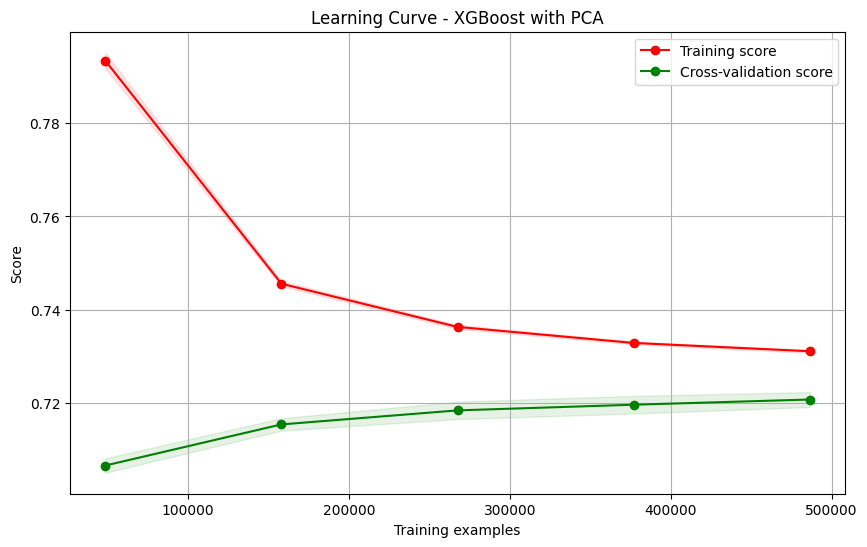

In [11]:
from sklearn.model_selection import StratifiedKFold
# ======= Función para visualizar la curva de aprendizaje ======= #
def plot_learning_curve(estimator, title, X, y, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Genera la curva de aprendizaje de un modelo.
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Generar curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, train_sizes=train_sizes)

    # Calcular medias y desviaciones estándar
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Visualizar la variabilidad de entrenamiento y validación
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.grid()
    plt.show()


# Definir validación cruzada estratificada
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Aplicar la curva de aprendizaje con datos transformados por PCA
plot_learning_curve(model, "Learning Curve - XGBoost with PCA", X_train, y_train, cv=cv)

#### 4. Proceso de Exportación de Modelo

In [17]:
from sklearn.impute import SimpleImputer
import pickle
# Columnas numéricas y categóricas
numerical_cols = ['duration', 'tiempo_promedio_estacion', 'distancia_mts', 
                  'tiempo_promedio_pares', 'duration_normalized', 'velocidad_promedio_mts',
                  'viajes_por_dia', 'bike_usage', 'promedio_plan_duration_mes', 
                  'promedio_plan_duration_bicicleta']
categorical_cols = ['franja_horaria', 'estacion_año', 'dia_semana', 'hora_inicio', 'year', 'month']
target_col = 'passholder_type'

# Codificar la variable objetivo con LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train = train.with_columns(
    pl.Series(name='target_encoded', values=label_encoder.fit_transform(train[target_col].to_list()))
)

# Crear preprocesador con imputación y escalado/codificación
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Imputar valores faltantes con promedio
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Imputar valores faltantes con la moda
            ('encoder', OneHotEncoder(sparse_output=False))
        ]), categorical_cols)
    ]
)

# Crear pipeline completo con modelo
model = XGBClassifier(
    tree_method='hist',
    subsample=0.8,
    n_estimators=300,
    max_depth=7,
    learning_rate=0.2,
    colsample_bytree=0.8,
    objective='multi:softprob',
    eval_metric='mlogloss',
    device='cuda:0'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Dividir en conjuntos de entrenamiento y prueba
X = train.select(numerical_cols + categorical_cols).to_pandas()
y = train['target_encoded'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el pipeline
pipeline.fit(X_train, y_train)

# Evaluar el modelo
y_pred = pipeline.predict(X_test)
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))

# Exportar el pipeline como archivo pickle
with open('xgboost_pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

print("Pipeline exportado exitosamente como 'xgboost_pipeline.pkl'")


Reporte de clasificación:
              precision    recall  f1-score   support

 Annual Pass       0.78      0.24      0.36      6677
   Flex Pass       0.85      0.07      0.13      2250
Monthly Pass       0.75      0.91      0.82     77445
One Day Pass       0.52      0.10      0.17      8005
     Testing       1.00      0.07      0.12        15
     Walk-up       0.69      0.64      0.67     40732

    accuracy                           0.73    135124
   macro avg       0.77      0.34      0.38    135124
weighted avg       0.72      0.73      0.70    135124


Matriz de confusión:
[[ 1585     0  4605    18     0   469]
 [    3   164  1768     2     0   313]
 [  304    21 70632   208     0  6280]
 [   33     0  2772   786     0  4414]
 [    0     0     5     1     1     8]
 [  110     7 14009   501     0 26105]]
Pipeline exportado exitosamente como 'xgboost_pipeline.pkl'


In [20]:
# Guardar el LabelEncoder como un archivo pickle
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)